# Ticket categorization

In [6]:
# Local 
import random

# Third party
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# Tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
# Constants
TRAIN_DATA_PATH = "/home/ggupta/TicketPro/data/training_data.csv"
VALIDATION_DATA_PATH = "/home/ggupta/TicketPro/data/validation_data.csv"
MODEL_DIR_PATH = "/home/ggupta/TicketPro/models/"
LABELS_KEY = {"Software": 0,
            "Network": 1,
            "Hardware": 2}
VOCAB_SIZE = 2000
OOV_TOKEN = "<OOV>"
MAX_LENGTH=13
TRUNC_TYPE="post"
EMBEDDING_DIM = 16
NUM_EPOCHS=10

### Data preprocessing

In [8]:
def preprocess_data(data_path: str, label_key: dict):
    """ Makes sentences from ticket dataframes using relevant information for categorization.
    Shuffles the sentences. One-hot encodes each label for the sentence. 

    Args:
        data_path (str): path to dataframe csv
        label_key (dict): label mapping 

    Returns:
        sentences: list of strings
        labels: list of arrays 
    """

    data_df = pd.read_csv(data_path)
    brief_descriptions = data_df["Brief description"].tolist()
    subjects = data_df["Subject"].tolist()
    sentences = [x + ": " + y for x, y in zip(subjects, brief_descriptions)]
    labels = data_df["Category"].tolist()
    labels = [label_key[x] for x in labels]
    indices= list(range(len(sentences)))
    random.shuffle(indices)
    sentences = [sentences[i] for i in indices]
    labels = [labels[i] for i in indices]
    labels = to_categorical(labels, num_classes=len(label_key))

    return sentences, labels

In [9]:
# Get data and labels into lists
training_sentences, training_labels = preprocess_data(TRAIN_DATA_PATH, LABELS_KEY)
validation_sentences, validation_labels = preprocess_data(VALIDATION_DATA_PATH, LABELS_KEY)

# Tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(training_sentences)

training_sequences=tokenizer.texts_to_sequences(training_sentences)
training_sequences=pad_sequences(training_sequences,maxlen=MAX_LENGTH, truncating=TRUNC_TYPE)

validation_sequences=tokenizer.texts_to_sequences(validation_sentences)
validation_sequences=pad_sequences(validation_sequences,maxlen=MAX_LENGTH, truncating=TRUNC_TYPE)


### Building the model

In [19]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=training_sequences.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Setup the training parameters
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 13, 16)            32000     
                                                                 
 flatten_1 (Flatten)         (None, 208)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1254      
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
Total params: 33,275
Trainable params: 33,275
Non-trainable params: 0
_________________________________________________________________


In [20]:

# Train the model
history = model.fit(training_sequences, 
                        training_labels, 
                        epochs=NUM_EPOCHS, 
                        validation_data=(validation_sequences, validation_labels))

Epoch 1/10
5/5 [==============================] - 1s 69ms/step - loss: 1.1037 - accuracy: 0.2847 - val_loss: 1.0936 - val_accuracy: 0.3429
Epoch 2/10
5/5 [==============================] - 0s 16ms/step - loss: 1.0902 - accuracy: 0.4891 - val_loss: 1.0942 - val_accuracy: 0.4000
Epoch 3/10
5/5 [==============================] - 0s 16ms/step - loss: 1.0798 - accuracy: 0.5912 - val_loss: 1.0959 - val_accuracy: 0.3429
Epoch 4/10
5/5 [==============================] - 0s 17ms/step - loss: 1.0687 - accuracy: 0.7007 - val_loss: 1.0974 - val_accuracy: 0.3429
Epoch 5/10
5/5 [==============================] - 0s 16ms/step - loss: 1.0562 - accuracy: 0.7591 - val_loss: 1.0979 - val_accuracy: 0.3429
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 1.0416 - accuracy: 0.8394 - val_loss: 1.0977 - val_accuracy: 0.3429
Epoch 7/10
5/5 [==============================] - 0s 16ms/step - loss: 1.0251 - accuracy: 0.8540 - val_loss: 1.0975 - val_accuracy: 0.3714
Epoch 8/10
5/5 [===========

### Visualization

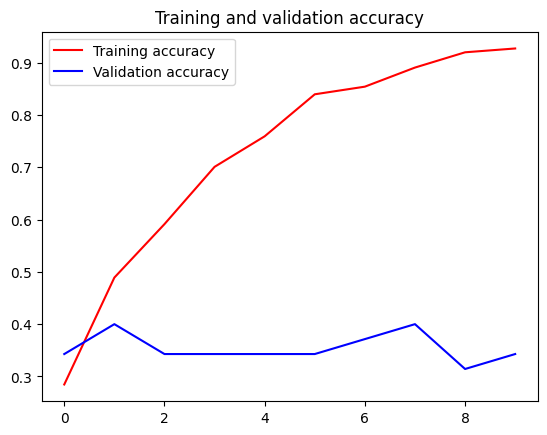

<Figure size 640x480 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()